In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

import numpy as np
import time
from numpy import arange, sin, pi, random

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Anomaly"]

In [2]:
from zoo.pipeline.api.keras.layers import Dense, Dropout
from zoo.pipeline.api.keras.models import Sequential
from bigdl.optim.optimizer import *

/private/var/folders/th/mq68kp9533z31prp3x7fm7rw0000gn/T/spark-09bd8c00-b9d0-4ef0-8d82-4ab72c8af97b/userFiles-e6248fb0-b024-4f73-99c4-b4ab46028294/analytics-zoo-0.1.0-SNAPSHOT-python-api.zip/zoo/common/nncontext.py:79: UserWarning: The compile time spark version may not compatible with the Spark runtime version. Compile time version is 2.0.0, runtime version is 2.2.0


## Read data from csv

In [3]:
df = pd.read_csv("data/CPU_example.csv")

In [4]:
df.shape

(360000, 3)

In [5]:
df.head()

,Time,CPU,Class
0,0,0.668029,0
1,1,-0.087067,0
2,2,0.108378,0
3,3,0.227231,0
4,4,0.295954,0


## Basic sanity check of data and normalization

In [6]:
# check for null data
df.isnull().values.any()

# Standard scaling : mean 0, stddev 1
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
df['CPU'] = preprocessing.StandardScaler().fit_transform(df['CPU'].values.reshape(-1, 1))
df.head()

,Time,CPU,Class
0,0,0.865492,0
1,1,-3.241536,0
2,2,-2.178497,0
3,3,-1.532043,0
4,4,-1.158252,0


<bound method Series.count of 0    164913
1    195087
Name: Class, dtype: int64>


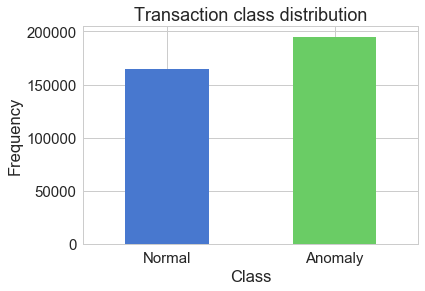

In [7]:
# let's explore the distribution of input data
count_classes = pd.value_counts(df['Class'], sort = False)
print(count_classes.count)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [8]:
# Just checking the relative counts
anomaly = df[df.Class == 1]
normal = df[df.Class == 0]

anomaly.shape

(195087, 3)

In [9]:
normal.shape

(164913, 3)

In [10]:
anomaly.CPU.describe()

count    195087.000000
mean          0.498250
std           0.558490
min          -2.015789
25%           0.128281
50%           0.497397
75%           0.864789
max          17.236686
Name: CPU, dtype: float64

In [11]:
normal.CPU.describe()

count    164913.000000
mean         -0.589415
std           1.083011
min          -5.633301
25%          -1.322399
50%          -0.588820
75%           0.145245
max           4.008205
Name: CPU, dtype: float64

## Any correlation between time and CPU metrics ?

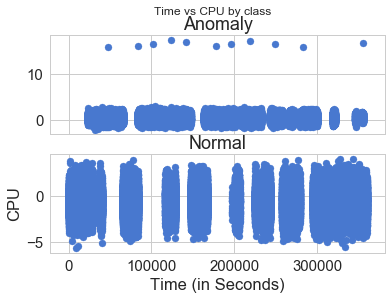

In [12]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time vs CPU by class')

ax1.scatter(anomaly.Time, anomaly.CPU)
ax1.set_title('Anomaly')

ax2.scatter(normal.Time, normal.CPU)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('CPU')
plt.show()

## Feature Re-engineering

In [13]:
indexed_df = df.set_index(["Time"])
df = indexed_df.rolling(10).mean()  ## mean over rolling window of size 10

df.loc[df['Class'] >= 0.5, 'Class'] = 1.0
df.loc[df['Class'] < 0.5, 'Class'] = 0.0

df = df[np.isfinite(df['CPU'])]  ## remove NaNs

In [14]:
df.head()

,CPU,Class
Time,,
9,-0.605786,0.0
10,-0.830194,0.0
11,-0.524666,0.0
12,-0.500997,0.0
13,-0.368182,0.0


## Split into training and test data

In [15]:
X_train, X_test = train_test_split(df.values[:, 1:2], test_size=0.2, random_state=RANDOM_SEED)
Y_train, Y_test = train_test_split(df.values[:, -1], test_size=0.2, random_state=RANDOM_SEED)

In [16]:
X_train.shape

(287992, 1)

In [17]:
X_test.shape

(71999, 1)

In [18]:
Y_train.shape

(287992,)

In [19]:
Y_test.shape
class_0 = list(filter(lambda x: x == 0.0, Y_test)) 
class_1 = list(filter(lambda x: x == 1.0, Y_test)) 
print(len(class_0), len(class_1))

32956 39043


# Build the Model

In [20]:
# Build the model
model = Sequential()

# 1st Fully connected layer + DropOut
model.add(Dense(16, input_shape=(X_train.shape[1],), activation = 'relu'))
model.add(Dropout(0.2))

# 2nd Fully connected layer + DropOut
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.2))

# 3rd Fully connected layer + DropOut
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.6))

# Output a Sigmoid since we need probability (normal / anomaly)
model.add(Dense(output_dim=1, activation = 'sigmoid'))
# model.summary()

creating: createZooKerasSequential
creating: createZooKerasDense
creating: createZooKerasDropout
creating: createZooKerasDense
creating: createZooKerasDropout
creating: createZooKerasDense
creating: createZooKerasDropout
creating: createZooKerasDense


# Train

In [21]:
log_dir = 'mylogdir'
app_name = 'myapp'

model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])

history = model.fit(X_train, Y_train,
                    nb_epoch=2,
                    batch_size=256)

train_summary = TrainSummary(log_dir=log_dir, app_name=app_name)

creating: createAdam
creating: createMSECriterion
creating: createTop1Accuracy
creating: createTrainSummary


In [22]:
loss = np.array(train_summary.read_scalar('Loss'))
print(loss)

[]


# Now predict on test set

In [23]:
predictions = model.predict(X_test)

In [24]:
predictions

PythonRDD[4542] at RDD at PythonRDD.scala:48

In [25]:
p = predictions.collect()
pr = []
for u in range(len(Y_test)):
    pr.append(p[u][0])

## find classes from probabilities
classes = list(map(lambda x: 1.0 if x > 0.5 else 0.0, p))

## check diff between predicted classes and real classes
df_prediction = pd.DataFrame({'Real Class' :np.array(Y_test)})
df_prediction['Prediction'] = classes
df_prediction[ df_prediction['Real Class'] != df_prediction['Prediction'] ]

,Real Class,Prediction


In [26]:
scores = model.evaluate(X_test, Y_test)
list(map(lambda x: (x.result, x.total_num, x.method), scores))

[(1.0, 71999, 'Top1Accuracy')]

# Load another test dataset drawn from same distribution

In [27]:
df = pd.read_csv("data/CPU_example_test.csv")

In [28]:
df.head()

,Time,CPU,Class
0,0,0.465224,0
1,1,0.018208,0
2,2,0.471135,0
3,3,0.392881,0
4,4,0.237540,0


In [29]:
df.isnull().values.any()
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
df['CPU'] = preprocessing.StandardScaler().fit_transform(df['CPU'].values.reshape(-1, 1))
df.head()

,Time,CPU,Class
0,0,0.310786,0
1,1,-1.908303,0
2,2,0.340129,0
3,3,-0.048341,0
4,4,-0.819487,0


In [30]:
indexed_df = df.set_index(["Time"])
df = indexed_df.rolling(10).mean()
df.loc[df['Class'] >= 0.5, 'Class'] = 1.0
df.loc[df['Class'] < 0.5, 'Class'] = 0.0
df = df[np.isfinite(df['CPU'])]  ## remove NaNs
df.head()

,CPU,Class
Time,,
9,-0.110524,0.0
10,-0.153550,0.0
11,-0.103063,0.0
12,-0.009661,0.0
13,-0.029654,0.0


In [31]:
X_test = df.values[:, 1:2]
Y_test = df.values[:, -1]

In [32]:
scores = model.evaluate(X_test, Y_test)
results = list(map(lambda x: (x.result, x.total_num, x.method), scores))
print(results)

[(1.0, 3591, 'Top1Accuracy')]


# Another test set

In [33]:
df = pd.read_csv("data/CPU_example_test_1.csv")

In [34]:
df.isnull().values.any()
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
df['CPU'] = preprocessing.StandardScaler().fit_transform(df['CPU'].values.reshape(-1, 1))
df.head()

,Time,CPU,Class
0,0,0.360386,1
1,1,-0.578935,0
2,2,0.036519,1
3,3,0.003221,0
4,4,0.439359,1


In [35]:
indexed_df = df.set_index(["Time"])
df = indexed_df.rolling(10).mean()
df.loc[df['Class'] >= 0.5, 'Class'] = 1.0
df.loc[df['Class'] < 0.5, 'Class'] = 0.0
df = df[np.isfinite(df['CPU'])]  ## remove NaNs
df.head()

,CPU,Class
Time,,
9,0.026021,1.0
10,0.016639,1.0
11,-0.062795,1.0
12,0.027721,1.0
13,0.066543,1.0


In [36]:
X_test = df.values[:, 1:2]
Y_test = df.values[:, -1]

In [37]:
scores = model.evaluate(X_test, Y_test)
results = list(map(lambda x: (x.result, x.total_num, x.method), scores))
print(results)

[(1.0, 3591, 'Top1Accuracy')]
